**Paper Reproduction :**
<br>
[Driver Identification Based on Vehicle Telematics Data using LSTM-Recurrent
Neural Network](https://ieeexplore-ieee-org.tudelft.idm.oclc.org/stamp/stamp.jsp?tp=&arnumber=8995202)


Cloning the repo

In [ ]:
!git clone https://github.com/Abeni18/Deep-LSTM-for-Driver-Identification-.git

fatal: destination path 'Deep-LSTM-for-Driver-Identification-' already exists and is not an empty directory.


In [ ]:
!pwd

/content


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!cd /content/Deep-LSTM-for-Driver-Identification-/

Uploading data - stored locally

## **Security Driving Dataset**

In [ ]:
from google.colab import files
uploaded = files.upload() #uploading the KIA Soul dataset and VehicularDataset

KeyboardInterrupt: ignored

In [ ]:
# Importing the libraries
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras.models import load_model
from sklearn.preprocessing import StandardScaler

The researchers have recorded data for 10 drivers (Class - A to J) <br> 
Description about the KIA Soul Dataset can be found here: [Section-4](https://arxiv.org/pdf/1704.05223.pdf)<br>


In [ ]:
# 'Read the file'
df= pd.read_csv('/content/Deep-LSTM-for-Driver-Identification-/Driving Data(KIA SOUL)_(150728-160714)_(10 Drivers_A-J) (1).csv')
df.head()
df.shape

(94380, 54)

Text(0.5, 0, 'Classes')

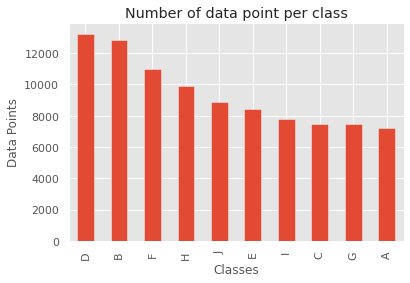

In [ ]:
# Visualizing Number of Data Points per Class
df['Class'].value_counts().plot(kind='bar', title='Number of data point per class')
plt.ylabel('Data Points')
plt.xlabel('Classes')

In [ ]:
def pre_process_encoder(df):

    'Features and label'
    X = df.drop('Class',1)
    y = df.Class  #Class -> Driver ID
   
    if "Car_Id" in X.columns:
        X.drop('Car_Id', axis=1, inplace=True)
    if 'Trip'in X.columns:
        X.drop('Trip', axis=1, inplace=True)
        
    return X,y

In [ ]:
X, y = pre_process_encoder(df)
print(y)

0        A
1        A
2        A
3        A
4        A
        ..
94375    D
94376    D
94377    D
94378    D
94379    D
Name: Class, Length: 94380, dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [ ]:
#'Split the data set into window samples'
from sklearn.preprocessing import LabelEncoder
def window(X1, y1):
    X_samples = []
    y_samples = []
    
     
    encoder = LabelEncoder()
    encoder.fit(y1)
    y1 = encoder.transform(y1)
    
    length = 16
    overlapsize = length//2
    n = y1.size    
 
    
    Xt = np.array(X1)
    yt= np.array(y1).reshape(-1,1)

    # for over the 263920  310495in jumps of 64
    for i in range(0, n , length-overlapsize):
        # grab from i to i+length
        sample_x = Xt[i:i+length,:]
        if (np.array(sample_x).shape[0]) == length: 
            X_samples.append(sample_x)

        sample_y = yt[i:i+length]
        if (np.array(sample_y).shape[0]) == length:
            y_samples.append(sample_y)

    return np.array(X_samples),  np.array(y_samples)

In [ ]:
#'for the label Select the maximum occuring value in the given array'
def max_occuring_label(sample):
    values, counts = np.unique(sample, return_counts=True)
    ind = np.argmax(counts)
    
    return values[ind] 

#'Creating y_sample label by taking only the maximum'

def label_y(y_value):
    y_samples_1 = []
    for i in range(len(y_value)):
        y_samples_1.append(max_occuring_label(y_value[i]))
        
    return np.array( y_samples_1 ).reshape(-1,1)

In [ ]:
"""TODO:Change window size ->change in accuracy"""

X_samples, y_samples = window(X, y)
print("Shape of dataset:",X_samples.shape) # Shape dependent on window size -> We can tinker with these values
max_label=max_occuring_label(y_samples)
print("Max Label:",max_label) #3 corresponds to D
#print(y_samples)

Shape of dataset: (11796, 16, 53)
Max Label: 3


In [ ]:
# Splitting the dataset into test and train
from sklearn.model_selection import train_test_split
# from keras.utils import to_categorical 
from tensorflow.keras.utils import to_categorical
""" to_categorical -> Converts the dataset into 
matrix which has binary values and has columns equal 
to the number of categories in the data."""


def rnn_dimension(X,y):
    X_samples, y_samples = window(X, y)
    y_samples = label_y(y_samples)

    #Shuffling 
    from sklearn.utils import shuffle
    X_samples,  y_samples = shuffle(X_samples, y_samples)

    # to catagory
    y_samples_cat = to_categorical(y_samples)


    X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn =train_test_split(X_samples, y_samples_cat, train_size=0.85)
    X_train,  y_train = shuffle(X_train_rnn, y_train_rnn)
    
    return X_train, y_train, X_test_rnn, y_test_rnn

In [ ]:
X_train_5,y_train_5, X_test_5,y_test_5 = rnn_dimension(X,y)

In [ ]:
print("Train X shape",X_train_5.shape)
print("Train Y shape",y_train_5.shape)
print("Test X shape",X_test_5.shape)
print("Test Y shape",y_test_5.shape)

Train X shape (10026, 16, 53)
Train Y shape (10026, 10)
Test X shape (1770, 16, 53)
Test Y shape (1770, 10)


In [ ]:
#List the available devices available in the local process ->CPU

"""TODO: Use GPU if training is too slow"""
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9044549539258377225
 xla_global_id: -1]

In [ ]:
#Normalizing the features
def normalizing(X_test):
            
            dim1=X_test.shape[1]
            dim2=X_test.shape[2]

            X_test_2d = X_test.reshape(-1,dim2)
            scale = StandardScaler()
            scale.fit(X_test_2d)

            X_test_scaled = scale.transform(X_test_2d)
            X_test_scaled = X_test_scaled.reshape(-1,dim1,dim2)

            return X_test_scaled

In [ ]:
# This commented part denotes the preexisting model conditions
# clean_model = load_model('/content/Deep-LSTM-for-Driver-Identification-/Model_clean_binary_cross_ICTAI_vehicle2_1')

In [ ]:
# X_test_normalized = normalizing(X_test_5)
# score = clean_model.evaluate(X_test_normalized, y_test_5, batch_size=50)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

In [ ]:
anomality_level = [0,0.25,0.5,0.75,1,1.25,1.5,1.75,2]

In [ ]:
def normalizing_2d(X):              
           
            scale = StandardScaler()
            scale.fit(X)

            X = scale.transform(X)
            
            return X

In [ ]:
def anomality_2d(X, anomaly): 

    X = np.array(X).reshape(-1,53 )
    mask = np.random.choice( X.shape[0], int(len(X)* .4), replace=False)

    # orgi_data[mask].shape

    X[mask] = X[mask]+X[mask]*anomaly

    return X

In [ ]:
X_train, X_test, y_train, y_test =train_test_split(X, y, train_size=0.85,shuffle=False)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
encoder = LabelEncoder()
encoder.fit(y)
y_dummy = encoder.transform(y)
y_dummy = to_categorical(y_dummy)

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
#y_dummy = to_categorical(y)

from keras.models import Sequential
from keras.layers import Dense
from sklearn.utils import shuffle
from keras import layers
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_dummy, train_size=0.85)



X_train_scaled = np.copy(normalizing_2d(X_train))

X_train, X_test_, y_train, y_test_ =train_test_split(X_train_scaled, y_train, train_size=0.99)
X_train,  y_train = shuffle(X_train, y_train)

### Training the Model

In [ ]:
mlp = Sequential()
mlp.add(Dense(160, input_dim=X_train.shape[1], activation='relu'))
mlp.add(layers.BatchNormalization())
mlp.add(layers.Dropout(0.5))
mlp.add(Dense(120, activation='relu'))
mlp.add(layers.BatchNormalization())
mlp.add(Dense(y_test.shape[1], activation='softmax'))
#mlp.add(Dense(1,activation='sigmoid'))
# mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','Precision','Recall','Recall'])
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
with tf.device('/GPU:0'):
    mlp_history = mlp.fit(X_train,y_train, epochs=20,batch_size=50, shuffle=True)

Epoch 1/20
1589/1589 [==============================] - 8s 4ms/step - loss: 1.1671 - accuracy: 0.5726 - precision: 0.7568 - recall: 0.4132 - recall_1: 0.4132
Epoch 2/20
1589/1589 [==============================] - 6s 4ms/step - loss: 0.6021 - accuracy: 0.7758 - precision: 0.8384 - recall: 0.7032 - recall_1: 0.7032
Epoch 3/20
1589/1589 [==============================] - 6s 4ms/step - loss: 0.4601 - accuracy: 0.8278 - precision: 0.8672 - recall: 0.7869 - recall_1: 0.7869
Epoch 4/20
1589/1589 [==============================] - 6s 4ms/step - loss: 0.3884 - accuracy: 0.8558 - precision: 0.8829 - recall: 0.8278 - recall_1: 0.8278
Epoch 5/20
1589/1589 [==============================] - 7s 4ms/step - loss: 0.3483 - accuracy: 0.8727 - precision: 0.8940 - recall: 0.8504 - recall_1: 0.8504
Epoch 6/20
1589/1589 [==============================] - 6s 4ms/step - loss: 0.3099 - accuracy: 0.8873 - precision: 0.9057 - recall: 0.8697 - recall_1: 0.8697
Epoch 7/20
1589/1589 [==============================

Testing accuracy of dataset on Nomralized test set

In [ ]:
X_test_normalized = normalizing_2d(X_test)


score = mlp.evaluate(X_test_normalized, y_test, batch_size=50)
print(score)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test Recall:',score[3])
print('Test F1 Score',score[4])

284/284 [==============================] - 1s 2ms/step - loss: 0.0597 - accuracy: 0.9863 - precision: 0.9883 - recall: 0.9850 - recall_1: 0.9850
[0.0597495436668396, 0.986296534538269, 0.9883053302764893, 0.9849544167518616, 0.9849544167518616]
Test loss: 0.0597495436668396
Test accuracy: 0.986296534538269
Test precision: 0.9883053302764893
Test Recall: 0.9849544167518616
Test F1 Score 0.9849544167518616


In [ ]:
anomality_2d

<function __main__.anomality_2d>

### Adding noise to the Dataset

In [ ]:
def mlp_acc_test(X_test, y_test):
    acc_noise_test = []
    acc_noise_test_rf_box = []
    
    # anomality_level = [0,0.2,0.4,0.6,0.8,1]
        
    for anomal in anomality_level:      

        i = 0
        iter_score = []
        while i < 5:
            X_test_anomal = np.copy(anomality_2d(X_test, anomal))
            X_test_normalized = normalizing_2d(X_test_anomal)


            score_1 = mlp.evaluate(X_test_normalized, y_test, batch_size=50)
            iter_score.append(score_1[1])
            i += 1
#             print(i)
  
        dif = max(iter_score) - min(iter_score) 
        score_2 = sum(iter_score)/len(iter_score)
        acc_noise_test.append(score_2)
        print('Avg Test loss:', score_2)
        print('Avg Test accuracy:', score_2)
        acc_noise_test_rf_box.append(dif)

    return acc_noise_test, acc_noise_test_rf_box

In [ ]:
X_test_normalized = normalizing_2d(X_test)


score = mlp.evaluate(X_test_normalized, y_test, batch_size=50)
print(score)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test Recall:',score[3])
print('Test F1 Score',score[4])

284/284 [==============================] - 1s 3ms/step - loss: 0.0597 - accuracy: 0.9863 - precision: 0.9883 - recall: 0.9850 - recall_1: 0.9850
[0.0597495436668396, 0.986296534538269, 0.9883053302764893, 0.9849544167518616, 0.9849544167518616]
Test loss: 0.0597495436668396
Test accuracy: 0.986296534538269
Test precision: 0.9883053302764893
Test Recall: 0.9849544167518616
Test F1 Score 0.9849544167518616


284/284 [==============================] - 1s 3ms/step - loss: 0.0597 - accuracy: 0.9863 - precision: 0.9883 - recall: 0.9850 - recall_1: 0.9850
Avg Test loss: 0.986296534538269
Avg Test accuracy: 0.986296534538269
284/284 [==============================] - 1s 3ms/step - loss: 5.7971 - accuracy: 0.3621 - precision: 0.3688 - recall: 0.3563 - recall_1: 0.3563
Avg Test loss: 0.36239317059516907
Avg Test accuracy: 0.36239317059516907
284/284 [==============================] - 1s 2ms/step - loss: 7.9400 - accuracy: 0.2750 - precision: 0.2766 - recall: 0.2693 - recall_1: 0.2693
Avg Test loss: 0.2731369614601135
Avg Test accuracy: 0.2731369614601135
284/284 [==============================] - 1s 2ms/step - loss: 8.6751 - accuracy: 0.2455 - precision: 0.2471 - recall: 0.2407 - recall_1: 0.2407
Avg Test loss: 0.24126580655574797
Avg Test accuracy: 0.24126580655574797
284/284 [==============================] - 1s 2ms/step - loss: 9.1838 - accuracy: 0.2279 - precision: 0.2299 - recall: 0.2242 - re

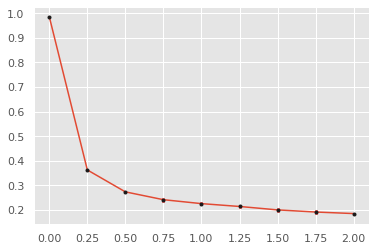

In [ ]:
mlp_noise_acc, mlp_noise_acc_box  = mlp_acc_test(X_test,y_test)
acc_mlp = []


for n in range(len(mlp_noise_acc)):
    acc_mlp.append(mlp_noise_acc[n])
    
# plt.plot(noise_sig,acc_mlp)
plt.plot(anomality_level,acc_mlp)
plt.errorbar(anomality_level,acc_mlp, mlp_noise_acc_box, fmt='.k', color='black',
             ecolor='red', elinewidth=3, capsize=0)

print(acc_mlp)

Avg Test loss: 0.9784558875467967
Avg Test accuracy: 0.9784558875467967
Avg Test loss: 0.6025711662075299
Avg Test accuracy: 0.6025711662075299
Avg Test loss: 0.34508723599632696
Avg Test accuracy: 0.34508723599632696
Avg Test loss: 0.3367026912481458
Avg Test accuracy: 0.3367026912481458
Avg Test loss: 0.24026983117892212
Avg Test accuracy: 0.24026983117892212
Avg Test loss: 0.2065974429610793
Avg Test accuracy: 0.2065974429610793
Avg Test loss: 0.19639047820866004
Avg Test accuracy: 0.19639047820866004
Avg Test loss: 0.19427844882390338
Avg Test accuracy: 0.19427844882390338
Avg Test loss: 0.16268983541710816
Avg Test accuracy: 0.16268983541710816
[0.9784558875467967, 0.6025711662075299, 0.34508723599632696, 0.3367026912481458, 0.24026983117892212, 0.2065974429610793, 0.19639047820866004, 0.19427844882390338, 0.16268983541710816]


<ErrorbarContainer object of 3 artists>

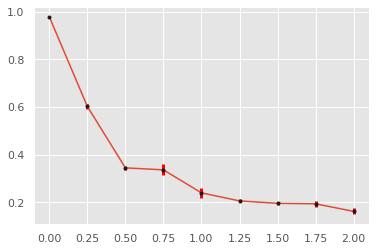

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =train_test_split(X, y, train_size=0.85)

X_train_scaled = np.copy(normalizing_2d(X_train))


from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics



def acc_noise_test_dt(X_train, y_train ,X_test , y_test):
    
    dt = DecisionTreeClassifier()
    dt.fit(X_train,y_train)

    acc_noise_test_dt = []
    acc_noise_test_rf_box = []

    for anomal in anomality_level:
       
        iter_score=[]
        for i in range(10):
            
            X_test_anomal = np.copy(anomality_2d(X_test, anomal))
            X_test_normalized = normalizing_2d(X_test_anomal)
           

            'Decision Tree'
            y_pred_dt = dt.predict(X_test_normalized)   
            acc_n = metrics.accuracy_score(y_test, y_pred_dt)
            
            iter_score.append(acc_n)
            
        dif = max(iter_score) - min(iter_score)    
        score_2 = sum(iter_score)/len(iter_score)
        acc_noise_test_dt.append(score_2)
        print('Avg Test loss:', score_2)
        print('Avg Test accuracy:', score_2)
        acc_noise_test_rf_box.append(dif)
            

        
    return  acc_noise_test_dt, acc_noise_test_rf_box


dt_noise_acc,dt_noise_acc_box = acc_noise_test_dt(X_train_scaled, y_train, X_test, y_test)
acc_dt = []
# anomality_level = [0,0.2,0.4,0.6,0.8,1]
for n in range(len(dt_noise_acc)):
    acc_dt.append(dt_noise_acc[n])


print(acc_dt)
plt.plot(anomality_level,acc_dt)
plt.errorbar(anomality_level,acc_dt, dt_noise_acc_box, fmt='.k', color='black',
             ecolor='red', elinewidth=3, capsize=0)


=
0.991947446492901
=
0.6234301052482871
=
0.38531468531468527
=
0.33249982340891426
=
0.2707918344281981
=
0.23882178427632975
=
0.2205481387299569
=
0.2186409550045914
=
0.21188811188811188
[0.991947446492901, 0.6234301052482871, 0.38531468531468527, 0.33249982340891426, 0.2707918344281981, 0.23882178427632975, 0.2205481387299569, 0.2186409550045914, 0.21188811188811188]


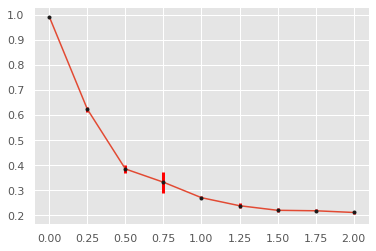

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics



def acc_noise_test_rf(X_train, y_train ,X_test , y_test):
    
    rf = RandomForestClassifier(n_estimators=20)
    rf.fit(X_train, y_train)

    acc_noise_test_rf = []
    acc_noise_test_rf_box = []
    
    for anomal in anomality_level:
       
        iter_score=[]
        for i in range(10):
            
            X_test_anomal = np.copy(anomality_2d(X_test, anomal))
            X_test_normalized = normalizing_2d(X_test_anomal)           

        
            'Random Forest'
            y_pred_rf =rf.predict(X_test_normalized) 
            acc_n = metrics.accuracy_score(y_test, y_pred_rf)
            iter_score.append(acc_n)
#             print(acc_n)
        
        dif = max(iter_score) - min(iter_score)
        acc_noise_test_rf_box.append(dif)
        score_2 = sum(iter_score)/len(iter_score)
        acc_noise_test_rf.append(score_2)
        
        print("=")
        print(score_2)
        
        
    return (acc_noise_test_rf,acc_noise_test_rf_box)


    
rf_noise_acc, rf_noise_acc_box = acc_noise_test_rf(X_train_scaled, y_train, X_test, y_test)
acc_rf = []
for n in range(len(rf_noise_acc)):
    acc_rf.append(rf_noise_acc[n])
    
# plt.plot(noise_sig,acc_rf,'or')
# plt.plot()
plt.plot(anomality_level,acc_rf)
plt.errorbar(anomality_level,acc_rf, rf_noise_acc_box, fmt='.k', color='black',
             ecolor='red', elinewidth=3, capsize=0)
# plt.boxplot(noise_sig,rf_noise_acc_box)
print(acc_rf)

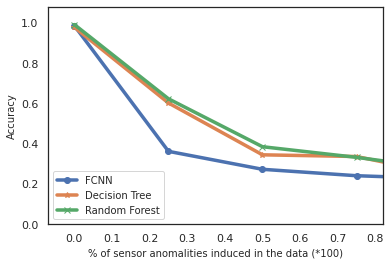

In [ ]:

#mpl.style.use('seaborn-poster')
fig2 = plt.figure()
plt.axis([-0.07,.82,0,1.08])
# anomality_level = [0,0.2,0.4,0.6,0.8,1]
# noise_sig = anomality_level 

# plt.plot(anomality_level[:10],acc[:10], marker='^' ,label="LSTM", linewidth=3.5)
plt.plot(anomality_level[:10], acc_mlp[:10], marker='o', label="FCNN", linewidth=3.5)
plt.plot(anomality_level[:10],acc_dt[:10], marker='*', label="Decision Tree", linewidth=3.5)
plt.plot(anomality_level[:10],acc_rf[:10], marker='x', label="Random Forest", linewidth=3.5)

plt.xlabel("% of sensor anomalities induced in the data (*100)" , fontsize=10)
plt.ylabel("Accuracy", fontsize=10)
# plt.title("Accuracy on noisy data")
plt.legend(loc=3, fontsize=10)
#plt.grid()

In [ ]:
average_acc_mlp=np.mean(acc_mlp)
average_acc_dt=np.mean(acc_dt)
average_acc_rf=np.mean(acc_rf)

array=[average_acc_mlp,average_acc_dt,average_acc_rf]
print(array)

[0.31973660522037084, 0.36256033528760806, 0.3882092094213306]


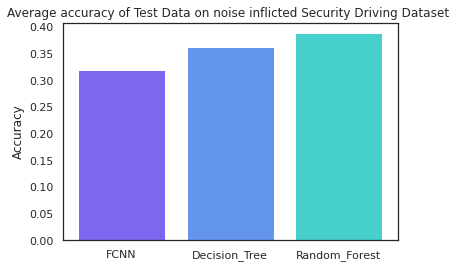

In [ ]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
 
# create a dataset
height = [average_acc_mlp, average_acc_dt, average_acc_rf]
bars = ('FCNN', 'Decision_Tree', 'Random_Forest')
x_pos = np.arange(len(bars))

import seaborn as sns
sns.set_theme()
sns.set_style("white")

# Create bars with different colors
plt.bar(x_pos, height, color=['mediumslateblue', 'cornflowerblue', 'mediumturquoise'])

# Create names on the x-axis
plt.ylabel('Accuracy')
plt.title("Average accuracy of Test Data on noise inflicted Security Driving Dataset ")
plt.xticks(x_pos, bars)

# Show graph
plt.show()

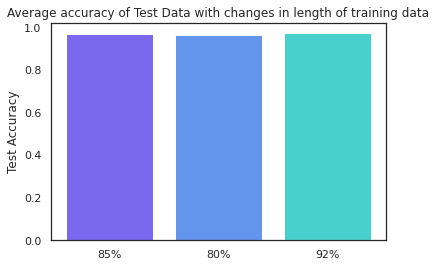

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
# create a dataset
height = [0.9696, 0.963, 0.972]
bars = ('85%', '80%', '92%')
x_pos = np.arange(len(bars))

import seaborn as sns
sns.set_theme()
sns.set_style("white")

# Create bars with different colors
plt.bar(x_pos, height, color=['mediumslateblue', 'cornflowerblue', 'mediumturquoise'])

# Create names on the x-axis
plt.ylabel('Test Accuracy')
plt.title("Average accuracy of Test Data with changes in length of training data")
plt.xticks(x_pos, bars)

# Show graph
plt.show()